In [1]:
!pip install "etna[all]@git+https://github.com/etna-team/etna.git@master"
!pip install sktime

  Cloning https://github.com/etna-team/etna.git (to revision master) to /tmp/pip-install-61cj861w/etna_eb7b04f816134a1ca7066d5b8dcb271d
  Running command git clone --filter=blob:none --quiet https://github.com/etna-team/etna.git /tmp/pip-install-61cj861w/etna_eb7b04f816134a1ca7066d5b8dcb271d
  Resolved https://github.com/etna-team/etna.git to commit 5adb89cf33e129d3b612551553ff22b02047b8ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install torch

In [7]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from sklearn.preprocessing import StandardScaler
from etna.datasets import TSDataset
from etna.transforms import LagTransform, MeanTransform, StdTransform

from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K

In [8]:
target_df = pd.read_csv('ETHUSDT_1d.csv', delimiter=',')
regressor_df = pd.read_csv('BTCUSDT_1d.csv', delimiter=',')
# добавляем новый признак (разница между макс и мин ценой за день)
regressor_df['diff_ETH'] = target_df['high'] - target_df['low']
regressor_df = regressor_df.rename(columns={
    'open': 'open_BTC',
    'high': 'high_BTC',
    'low': 'low_BTC',
    'close': 'close_BTC',
    'volume': 'volume_BTC'
})
regressor_df['volume_ETH'] = target_df['volume']
target_df = target_df.drop('volume', axis=1)
# делаем лаги
for i in regressor_df.columns:
  if i != 'timestamp':
    regressor_df[f'lag_2_{i}'] = regressor_df[i].shift(2)
    regressor_df[f'{i}'] = regressor_df[i].shift(1)

for i in range(1, 4):
  regressor_df[f'open_lag_{i}'] = target_df['open'].shift(i)

target_df = target_df.loc[3:]
regressor_df = regressor_df.loc[3:]
display(target_df)
display(regressor_df)


,timestamp,open,high,low,close
3,2017-08-20,289.41,300.53,282.85,299.10
4,2017-08-21,299.10,346.52,294.60,323.29
5,2017-08-22,321.04,330.41,144.21,309.80
6,2017-08-23,312.25,324.99,309.41,315.74
7,2017-08-24,315.74,328.04,314.01,323.42
...,...,...,...,...,...
2762,2025-03-10,2020.43,2152.40,1810.01,1865.10
2763,2025-03-11,1865.11,1963.20,1754.28,1923.43
2764,2025-03-12,1923.42,1960.00,1829.72,1908.20
2765,2025-03-13,1908.20,1923.09,1821.81,1864.59


,timestamp,open_BTC,high_BTC,low_BTC,close_BTC,volume_BTC,diff_ETH,volume_ETH,lag_2_open_BTC,lag_2_high_BTC,lag_2_low_BTC,lag_2_close_BTC,lag_2_volume_BTC,lag_2_diff_ETH,lag_2_volume_ETH,open_lag_1,open_lag_2,open_lag_3
3,2017-08-20,4108.37,4184.69,3850.00,4139.98,381.309763,21.90,2.146198e+03,4285.08,4371.52,3938.77,4108.37,1199.888264,27.85,9.537846e+03,293.31,302.00,301.13
4,2017-08-21,4120.98,4211.08,4032.62,4086.29,467.083022,17.68,2.510139e+03,4108.37,4184.69,3850.00,4139.98,381.309763,21.90,2.146198e+03,289.41,293.31,302.00
5,2017-08-22,4069.13,4119.62,3911.79,4016.00,691.743060,51.92,5.219445e+03,4120.98,4211.08,4032.62,4086.29,467.083022,17.68,2.510139e+03,299.10,289.41,293.31
6,2017-08-23,4016.00,4104.82,3400.00,4040.00,966.684858,186.20,7.956351e+03,4069.13,4119.62,3911.79,4016.00,691.743060,51.92,5.219445e+03,321.04,299.10,289.41
7,2017-08-24,4040.00,4265.80,4013.89,4114.01,1001.136565,15.58,8.665726e+03,4016.00,4104.82,3400.00,4040.00,966.684858,186.20,7.956351e+03,312.25,321.04,299.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,2025-03-10,86222.46,86500.00,80000.00,80734.37,26115.393450,222.34,6.016716e+05,86801.74,86897.25,85218.47,86222.45,12989.230540,129.87,3.287931e+05,2203.57,2141.60,2202.21
2763,2025-03-11,80734.48,84123.46,77459.91,78595.86,47633.384050,342.39,1.248745e+06,86222.46,86500.00,80000.00,80734.37,26115.393450,222.34,6.016716e+05,2020.43,2203.57,2141.60
2764,2025-03-12,78595.86,83617.40,76606.00,82932.99,48770.068530,208.92,1.171428e+06,80734.48,84123.46,77459.91,78595.86,47633.384050,342.39,1.248745e+06,1865.11,2020.43,2203.57
2765,2025-03-13,82932.99,84539.85,80607.65,83680.12,31933.986000,130.28,7.887397e+05,78595.86,83617.40,76606.00,82932.99,48770.068530,208.92,1.171428e+06,1923.42,1865.11,2020.43


In [9]:
target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])
y_test_monthly = target_df['timestamp'].dt.strftime('%Y-%m')
X = regressor_df.set_index("timestamp")
y = target_df.set_index('timestamp')
y = y['open']
X_train = X[:'2025-03-01']
X_test = X['2025-03-02':]
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)
y_train = y[:'2025-03-01']
y_test = y['2025-03-02':]
print(y_train.shape)
print(y_test.shape)

(2751, 17)
(13, 17)
(2751,)
(13,)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3387514.2500 - mape: 93.1075
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 417838.7188 - mape: 57.1009
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127380.4531 - mape: 34.8729
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77176.7500 - mape: 28.8900
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47149.3828 - mape: 25.3318
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34869.7734 - mape: 19.6603
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20721.3008 - mape: 15.3568
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16201.9473 - mape: 12.7763
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11856.9385 - mape: 9.4820
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10907.5430 - mape: 8.6042
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9170.3242 - mape: 7.0471
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

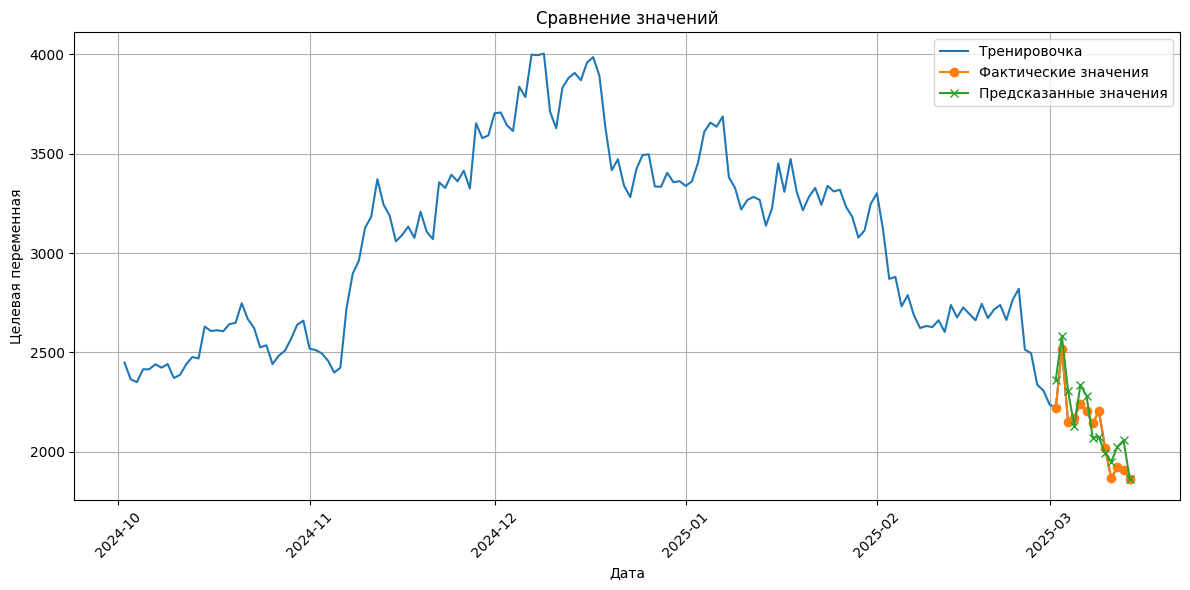

In [10]:
class MAPE(Metric):
    def __init__(self, name='mape'):
        super(MAPE, self).__init__(name=name)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_error = K.abs((y_true - y_pred) / K.maximum(K.abs(y_true), K.epsilon()))
        sum_abs_error = K.sum(abs_error)
        self.total.assign_add(sum_abs_error)
        self.count.assign_add(K.cast(K.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total / self.count * 100

    def reset_states(self):
        self.total.assign(0.)
        self.count.assign(0.)

class SimpleNN:
    def __init__(self, input_shape, hidden_units=128):
        self.model = models.Sequential([
            layers.Dense(hidden_units, activation='relu', input_shape=(input_shape,)), # первый слой на входе кол-во признаков на выходе hidden_units нейронов
            layers.Dense(hidden_units//2, activation='relu'),
            layers.Dense(hidden_units//4, activation='relu'),
            layers.Dense(1)
        ])
        # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(optimizer='adam', # компилируем модельку
                          loss='mse',
                          metrics=[MAPE()])

    def fit(self, X_train, y_train, epochs=100, batch_size=32):
        history = self.model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=batch_size)
        return history

    def evaluate(self, X_test, y_test): # оценка модели с помощбю метрик
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        return self.model.predict(X).flatten()

# Обучение
model = SimpleNN(input_shape=X_train.shape[1])
history = model.fit(X_train, y_train, epochs=50, batch_size=16)
# Оценка
loss, mape = model.evaluate(X_test, y_test)
print(f"Test MAPE: {mape:.2f}%")
# Предсказания
y_pred = model.predict(X_test)
# График
plt.figure(figsize=(12, 6))
plt.plot(y.index[2600:], y[2600:], label='Тренировочка')
plt.plot(y.index[2751:], y_test, label='Фактические значения', marker='o')
plt.plot(y.index[2751:], y_pred, label='Предсказанные значения', marker='x')
plt.xlabel('Дата')
plt.ylabel('Целевая переменная')
plt.title('Сравнение значений')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
target_df = pd.read_csv('ETHUSDT_1d.csv', delimiter=',')
regressor_df = pd.read_csv('BTCUSDT_1d.csv', delimiter=',')
# добавляем новый признак (разница между макс и мин ценой за день)
regressor_df['diff_ETH'] = target_df['high'] - target_df['low']
regressor_df = regressor_df.rename(columns={
    'open': 'open_BTC',
    'high': 'high_BTC',
    'low': 'low_BTC',
    'close': 'close_BTC',
    'volume': 'volume_BTC'
})
regressor_df['volume_ETH'] = target_df['volume']
target_df = target_df.drop('volume', axis=1)
# делаем лаги
for i in regressor_df.columns:
  if i != 'timestamp':
    regressor_df[f'lag_2_{i}'] = regressor_df[i].shift(2)
    regressor_df[f'{i}'] = regressor_df[i].shift(1)

for i in range(1, 4):
  regressor_df[f'open_lag_{i}'] = target_df['open'].shift(i)
  regressor_df[f'high_lag_{i}'] = target_df['high'].shift(i)
  regressor_df[f'low_lag_{i}'] = target_df['low'].shift(i)
  regressor_df[f'close_lag_{i}'] = target_df['close'].shift(i)

target_df = target_df.loc[3:]
regressor_df = regressor_df.loc[3:]
display(target_df)
display(regressor_df)

,timestamp,open,high,low,close
3,2017-08-20,289.41,300.53,282.85,299.10
4,2017-08-21,299.10,346.52,294.60,323.29
5,2017-08-22,321.04,330.41,144.21,309.80
6,2017-08-23,312.25,324.99,309.41,315.74
7,2017-08-24,315.74,328.04,314.01,323.42
...,...,...,...,...,...
2762,2025-03-10,2020.43,2152.40,1810.01,1865.10
2763,2025-03-11,1865.11,1963.20,1754.28,1923.43
2764,2025-03-12,1923.42,1960.00,1829.72,1908.20
2765,2025-03-13,1908.20,1923.09,1821.81,1864.59


,timestamp,open_BTC,high_BTC,low_BTC,close_BTC,volume_BTC,diff_ETH,volume_ETH,lag_2_open_BTC,lag_2_high_BTC,...,low_lag_1,close_lag_1,open_lag_2,high_lag_2,low_lag_2,close_lag_2,open_lag_3,high_lag_3,low_lag_3,close_lag_3
3,2017-08-20,4108.37,4184.69,3850.00,4139.98,381.309763,21.90,2.146198e+03,4285.08,4371.52,...,278.00,290.91,302.00,311.79,283.94,293.96,301.13,312.18,298.00,302.00
4,2017-08-21,4120.98,4211.08,4032.62,4086.29,467.083022,17.68,2.510139e+03,4108.37,4184.69,...,282.85,299.10,293.31,299.90,278.00,290.91,302.00,311.79,283.94,293.96
5,2017-08-22,4069.13,4119.62,3911.79,4016.00,691.743060,51.92,5.219445e+03,4120.98,4211.08,...,294.60,323.29,289.41,300.53,282.85,299.10,293.31,299.90,278.00,290.91
6,2017-08-23,4016.00,4104.82,3400.00,4040.00,966.684858,186.20,7.956351e+03,4069.13,4119.62,...,144.21,309.80,299.10,346.52,294.60,323.29,289.41,300.53,282.85,299.10
7,2017-08-24,4040.00,4265.80,4013.89,4114.01,1001.136565,15.58,8.665726e+03,4016.00,4104.82,...,309.41,315.74,321.04,330.41,144.21,309.80,299.10,346.52,294.60,323.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,2025-03-10,86222.46,86500.00,80000.00,80734.37,26115.393450,222.34,6.016716e+05,86801.74,86897.25,...,1989.66,2020.41,2141.60,2234.93,2105.06,2203.58,2202.21,2258.47,2101.82,2141.60
2763,2025-03-11,80734.48,84123.46,77459.91,78595.86,47633.384050,342.39,1.248745e+06,86222.46,86500.00,...,1810.01,1865.10,2203.57,2212.00,1989.66,2020.41,2141.60,2234.93,2105.06,2203.58
2764,2025-03-12,78595.86,83617.40,76606.00,82932.99,48770.068530,208.92,1.171428e+06,80734.48,84123.46,...,1754.28,1923.43,2020.43,2152.40,1810.01,1865.10,2203.57,2212.00,1989.66,2020.41
2765,2025-03-13,82932.99,84539.85,80607.65,83680.12,31933.986000,130.28,7.887397e+05,78595.86,83617.40,...,1829.72,1908.20,1865.11,1963.20,1754.28,1923.43,2020.43,2152.40,1810.01,1865.10


In [12]:
target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])
y_test_monthly = target_df['timestamp'].dt.strftime('%Y-%m')
X = regressor_df.set_index("timestamp")
y = target_df.set_index('timestamp')
X_train = X[:'2025-03-01']
X_test = X['2025-03-02':]

display(X_train.head())
print()
display(X_test.head())
print()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)
y_train = y[:'2025-03-01']
y_test = y['2025-03-02':]
print(y_train.shape)
print(y_test.shape)
display(y_train.head())
print()
display(y_test.head())

<ipython-input-12-b870fd5e92a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])


,open_BTC,high_BTC,low_BTC,close_BTC,volume_BTC,diff_ETH,volume_ETH,lag_2_open_BTC,lag_2_high_BTC,lag_2_low_BTC,...,low_lag_1,close_lag_1,open_lag_2,high_lag_2,low_lag_2,close_lag_2,open_lag_3,high_lag_3,low_lag_3,close_lag_3
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-20,4108.37,4184.69,3850.00,4139.98,381.309763,21.90,2146.19773,4285.08,4371.52,3938.77,...,278.00,290.91,302.00,311.79,283.94,293.96,301.13,312.18,298.00,302.00
2017-08-21,4120.98,4211.08,4032.62,4086.29,467.083022,17.68,2510.13871,4108.37,4184.69,3850.00,...,282.85,299.10,293.31,299.90,278.00,290.91,302.00,311.79,283.94,293.96
2017-08-22,4069.13,4119.62,3911.79,4016.00,691.743060,51.92,5219.44542,4120.98,4211.08,4032.62,...,294.60,323.29,289.41,300.53,282.85,299.10,293.31,299.90,278.00,290.91
2017-08-23,4016.00,4104.82,3400.00,4040.00,966.684858,186.20,7956.35088,4069.13,4119.62,3911.79,...,144.21,309.80,299.10,346.52,294.60,323.29,289.41,300.53,282.85,299.10
2017-08-24,4040.00,4265.80,4013.89,4114.01,1001.136565,15.58,8665.72569,4016.00,4104.82,3400.00,...,309.41,315.74,321.04,330.41,144.21,309.80,299.10,346.52,294.60,323.29


,open_BTC,high_BTC,low_BTC,close_BTC,volume_BTC,diff_ETH,volume_ETH,lag_2_open_BTC,lag_2_high_BTC,lag_2_low_BTC,...,low_lag_1,close_lag_1,open_lag_2,high_lag_2,low_lag_2,close_lag_2,open_lag_3,high_lag_3,low_lag_3,close_lag_3
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-02,84349.95,86558.00,83824.78,86064.53,25785.05464,138.41,4.464307e+05,84708.57,85120.00,78258.52,...,2142.73,2217.39,2307.72,2314.18,2076.26,2237.59,2336.38,2381.60,2230.57,2307.72
2025-03-03,86064.54,95000.00,85050.60,94270.00,54889.09045,378.54,1.266685e+06,84349.95,86558.00,83824.78,...,2172.04,2518.11,2237.59,2281.14,2142.73,2217.39,2307.72,2314.18,2076.26,2237.59
2025-03-04,94269.99,94416.46,85117.11,86220.61,59171.10218,425.65,1.109565e+06,86064.54,95000.00,85050.60,...,2097.91,2149.01,2217.40,2550.58,2172.04,2518.11,2237.59,2281.14,2142.73,2217.39
2025-03-05,86221.16,88967.52,81500.00,87281.98,55609.10706,228.68,1.257822e+06,94269.99,94416.46,85117.11,...,1993.20,2171.51,2518.12,2523.56,2097.91,2149.01,2217.40,2550.58,2172.04,2518.11
2025-03-06,87281.98,91000.00,86334.53,90606.01,38264.01163,118.48,6.871308e+05,86221.16,88967.52,81500.00,...,2155.03,2241.59,2149.02,2221.88,1993.20,2171.51,2518.12,2523.56,2097.91,2149.01



(2751, 26)
(13, 26)
(2751, 4)
(13, 4)


,open,high,low,close
timestamp,,,,
2017-08-20,289.41,300.53,282.85,299.10
2017-08-21,299.10,346.52,294.60,323.29
2017-08-22,321.04,330.41,144.21,309.80
2017-08-23,312.25,324.99,309.41,315.74
2017-08-24,315.74,328.04,314.01,323.42


,open,high,low,close
timestamp,,,,
2025-03-02,2217.40,2550.58,2172.04,2518.11
2025-03-03,2518.12,2523.56,2097.91,2149.01
2025-03-04,2149.02,2221.88,1993.20,2171.51
2025-03-05,2171.50,2273.51,2155.03,2241.59
2025-03-06,2241.59,2319.99,2176.90,2202.20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3316649.7500 - mape: 372.8690
Epoch 2/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 378353.2188 - mape: 226.2568
Epoch 3/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 174317.1719 - mape: 160.9234
Epoch 4/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 114172.1562 - mape: 153.8244
Epoch 5/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 74115.3438 - mape: 137.6773
Epoch 6/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 53642.9062 - mape: 121.5432
Epoch 7/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 32965.6602 - mape: 91.7006
Epoch 8/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20875.9863 - mape: 66.0150
Epoch 9/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14874.2588 - mape: 50.2083
Epoch 10/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10207.7979 - mape: 35.8532
Epoch 11/60
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8960.8057 - mape: 30.4545
Epoch 12/60
172/172 ━━━━━━━━━━━

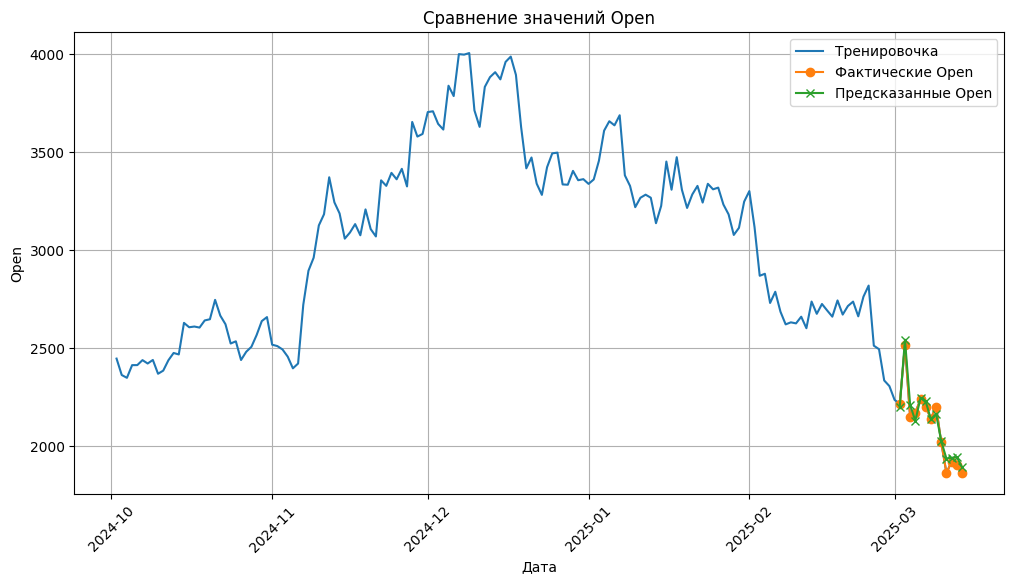

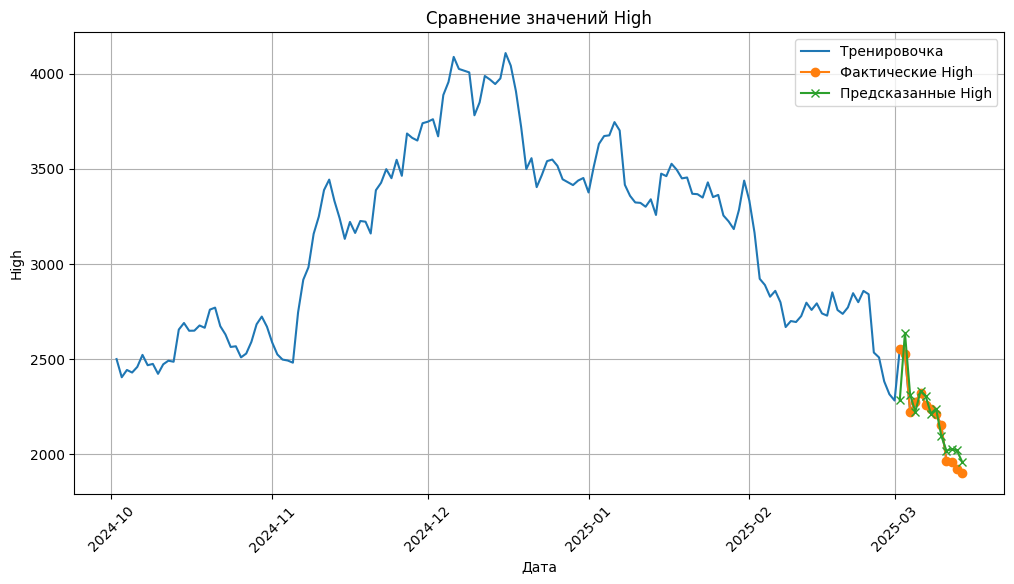

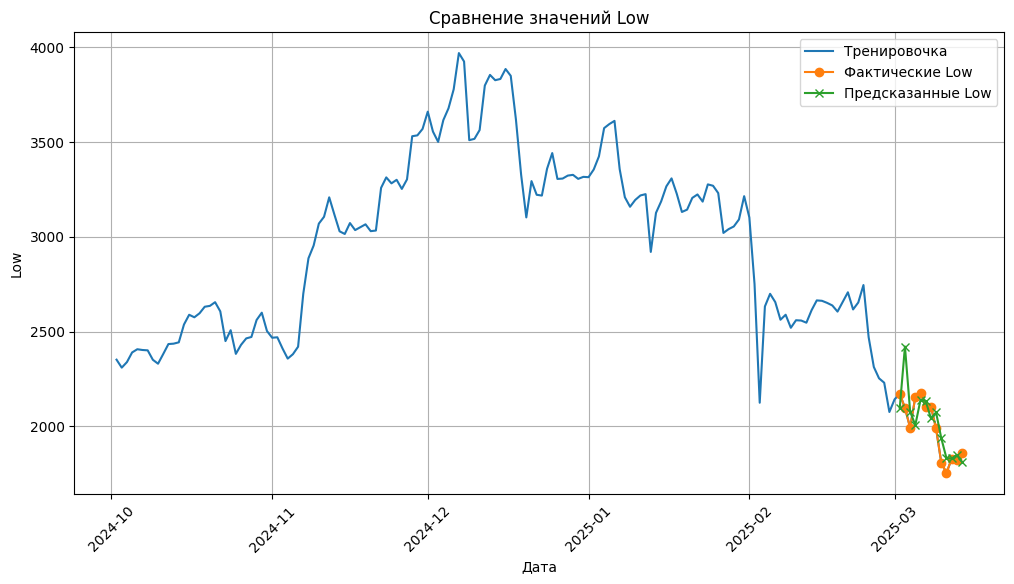

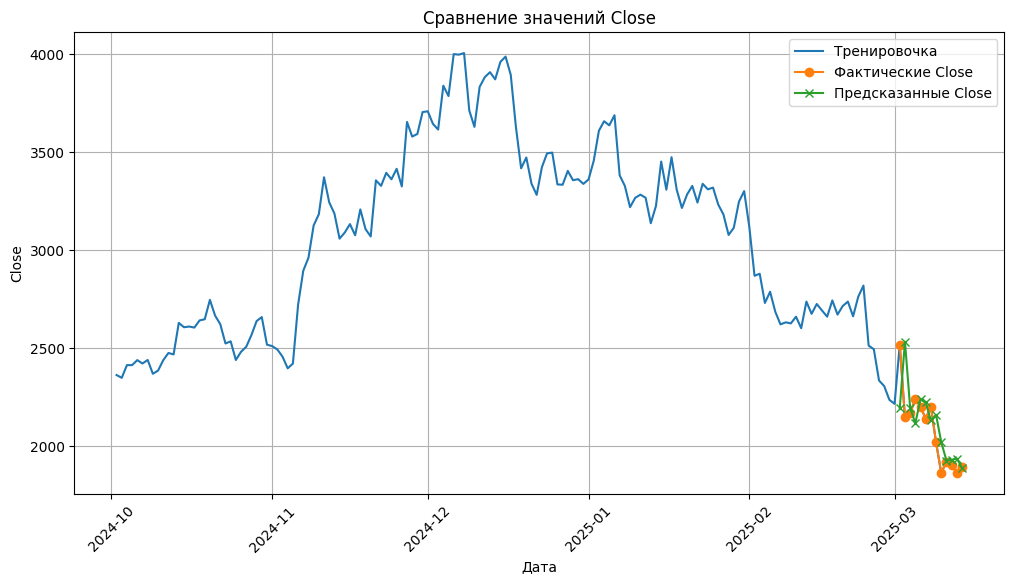

In [13]:


class MAPE(Metric):
    def __init__(self, name='mape'):
        super(MAPE, self).__init__(name=name)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        abs_error = K.abs((y_true - y_pred) / K.maximum(K.abs(y_true), K.epsilon()))
        sum_abs_error = K.sum(abs_error)
        self.total.assign_add(sum_abs_error)
        self.count.assign_add(K.cast(K.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total / self.count * 100

    def reset_states(self):
        self.total.assign(0.)
        self.count.assign(0.)

class MultiOutputNN:
    def __init__(self, input_shape, hidden_units=128, num_outputs=4):
        self.model = models.Sequential([
            layers.Dense(hidden_units, activation='relu', input_shape=(input_shape,)),
            layers.Dense(hidden_units//2, activation='relu'),
            layers.Dense(hidden_units//4, activation='relu'),
            layers.Dense(num_outputs)
        ])
        self.model.compile(optimizer='adam',
                          loss='mse',
                          metrics=[MAPE()])

    def fit(self, X_train, y_train, epochs=100, batch_size=32):
        history = self.model.fit(X_train, y_train,
                                epochs=epochs,
                                batch_size=batch_size)
        return history

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict(self, X):
        return self.model.predict(X)

model = MultiOutputNN(input_shape=X_train.shape[1])
history = model.fit(X_train, y_train, epochs=60, batch_size=16)

loss, mape = model.evaluate(X_test, y_test)
print(f"Test MAPE: {mape:.2f}%")

predictions = model.predict(X_test)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), np.finfo(float).eps))) * 100
# берем предсказания для каждого таргета
pred_open = predictions[:, 0]
pred_high = predictions[:, 1]
pred_low = predictions[:, 2]
pred_close = predictions[:, 3]
# берем тестовые данные для каждого таргета
actual_open = y_test.iloc[:, 0]
actual_high = y_test.iloc[:, 1]
actual_low = y_test.iloc[:, 2]
actual_close = y_test.iloc[:, 3]
# считаем с помощью функции MAPE для каждого таргета
mape_open = calculate_mape(actual_open, pred_open)
mape_high = calculate_mape(actual_high, pred_high)
mape_low = calculate_mape(actual_low, pred_low)
mape_close = calculate_mape(actual_close, pred_close)

print()
print(f"Open MAPE: {mape_open:.2f}%")
print(f"High MAPE: {mape_high:.2f}%")
print(f"Low MAPE: {mape_low:.2f}%")
print(f"Close MAPE: {mape_close:.2f}%")

# График для Open
plt.figure(figsize=(12, 6))
plt.plot(y.index[2600:], y.iloc[2600:, 0], label='Тренировочка')
plt.plot(y.index[2751:], y_test.iloc[:, 0], label='Фактические Open', marker='o')
plt.plot(y.index[2751:], pred_open, label='Предсказанные Open', marker='x')
plt.xlabel('Дата')
plt.ylabel('Open')
plt.title('Сравнение значений Open')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
# График для High
plt.figure(figsize=(12, 6))
plt.plot(y.index[2600:], y.iloc[2600:, 1], label='Тренировочка')
plt.plot(y.index[2751:], y_test.iloc[:, 1], label='Фактические High', marker='o')
plt.plot(y.index[2751:], pred_high, label='Предсказанные High', marker='x')
plt.xlabel('Дата')
plt.ylabel('High')
plt.title('Сравнение значений High')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
# График для Low
plt.figure(figsize=(12, 6))
plt.plot(y.index[2600:], y.iloc[2600:, 2], label='Тренировочка')
plt.plot(y.index[2751:], y_test.iloc[:, 2], label='Фактические Low', marker='o')
plt.plot(y.index[2751:], pred_low, label='Предсказанные Low', marker='x')
plt.xlabel('Дата')
plt.ylabel('Low')
plt.title('Сравнение значений Low')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
# График для Close
plt.figure(figsize=(12, 6))
plt.plot(y.index[2600:], y.iloc[2600:, 3], label='Тренировочка')
plt.plot(y.index[2751:], y_test.iloc[:, 3], label='Фактические Close', marker='o')
plt.plot(y.index[2751:], pred_close, label='Предсказанные Close', marker='x')
plt.xlabel('Дата')
plt.ylabel('Close')
plt.title('Сравнение значений Close')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()